# **GeoSpy API:** Image Geo-localization and Classification

This notebook is a simple example of how to use the GeoSpy API to classify and geolocalize images. The API is a RESTful web service that allows you to send images and receive the classification and geolocalization of the image. 


## Installation

In [18]:
!pip install -q folium
!pip install -q matplotlib
!pip install -q aiohttp
!pip install -q asyncio
!pip install -q pillow


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

 ## Load An Image 🌃 

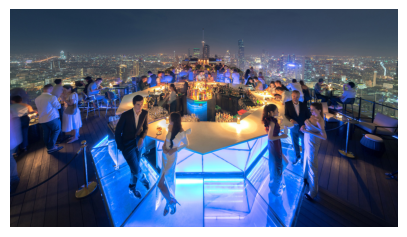

In [235]:
uploaded = "sample_images/bar.jpg"
image_path = uploaded
    
def load_image(image_path):
    if uploaded:
        
            image = Image.open(image_path)
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.axis('off')
            plt.show()
    else:
        print("No image uploaded. Please try again.")

load_image(image_path)


In [236]:
import aiohttp
import asyncio
import base64
import folium
from aiohttp import ClientTimeout
import nest_asyncio
nest_asyncio.apply()

## Define an async function to send the image to the API 📷

In [252]:
async def fetch_geolocation(image_path, top_k=5 ,use_classification=False, anti_cluster=False):
    ENDPOINT_URL = "YOUR_API_ENDPOINT"  # Replace with your actual API endpoint
    API_KEY = "YOUR_API_KEY"  # Replace with your actual API key
    
    # Note the supported image types are: jpeg, jpg, png, and webp
    async with aiohttp.ClientSession() as session:
        with open(image_path, "rb") as image_file:
            b64_image = base64.b64encode(image_file.read()).decode("utf-8")

        
        payload = {
            "image": b64_image,
            "key": API_KEY,  # Include the API key in the payload
            "top_k": top_k,  # Return the top 10 classes
            "use_classification" : use_classification,
            "anti_cluster" : anti_cluster
        }
        
        headers = {'Content-Type': 'application/json'}
        timeout = ClientTimeout(total=90)
        
        async with session.post(ENDPOINT_URL, json=payload, headers=headers, timeout=timeout) as response:
            if response.status == 200:
                return await response.json()
            else:
                print(f"Failed to fetch geolocation, status code: {response.status}")
                return None
            

## Encode the image and send it to the API 📞

In [255]:
# if this is the first time calling the api, it may take 30-60 seconds to load the model
geolocation = await fetch_geolocation(image_path)
geolocation

{'status': 200,
 'message': 'Success',
 'geo_predictions': [{'coordinates': [13.72344970703125, 100.53968811035156],
   'score': 0.018296463415026665},
  {'coordinates': [13.724499702453613, 100.54000091552734],
   'score': 0.01827954687178135},
  {'coordinates': [13.72487735748291, 100.54157257080078],
   'score': 0.018260624259710312},
  {'coordinates': [13.721040725708008, 100.52730560302734],
   'score': 0.01798492670059204},
  {'coordinates': [13.72313117980957, 100.51982879638672],
   'score': 0.016850670799613}]}

# Reponse 📬

```json
{
 "status": 200,
 "message": "Success",
 "geo_predictions": 
 [
    {
      "coordinates": [13.72344970703125, 100.53968811035156],"score": 0.018296463415026665
    },
  ]
}

```

So what does this mean? The API has returned a list of coordinates and scores. The coordinates are the latitude and longitude of the image. The score is how closely the features of the image match the features of the coordinates. Scores should not necessarily be compared between images, but they can be used to compare the quality of the predictions for a single image. The score is a value between 0 and 0.1, where the score indicates similarity in learned features between the image and the coordinates. The higher the score, the more similar the image is to learned features at that predicted location.

## Visualize the results on a map 🗺️

In [256]:
geolocation = geolocation["geo_predictions"]
# Extract the GPS coordinates and probabilities
gps_coordinates = [prediction["coordinates"] for prediction in geolocation]
probabilities = [prediction["score"] for prediction in geolocation]

# Normalize the probabilities
total_prob = sum(probabilities)
normalized_probs = [prob / total_prob for prob in probabilities]

# Combine coordinates with normalized probabilities
weighted_coordinates = [(lat, lon, weight*100) for (lat, lon), weight in zip(gps_coordinates, normalized_probs)]  # Multiply weight by 100 for visualization purposes

# Calculate the average location to center the map
avg_lat = sum(lat for lat, _, _ in weighted_coordinates) / len(weighted_coordinates)
avg_lon = sum(lon for _, lon, _ in weighted_coordinates) / len(weighted_coordinates)

# Create a map centered around the average coordinates
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=2)

HeatMap(weighted_coordinates, radius=15).add_to(m)

# Mark top coordinate
top_coordinate = gps_coordinates[0]
top_probability = normalized_probs[0]

folium.Marker(
    location=top_coordinate,
    popup=f"Top Prediction: {top_coordinate} with probability {top_probability:.4f}",
    icon=folium.Icon(color='red', icon='star')
).add_to(m)
# Display the map
m

## Use the API to classify the image (Beta Feature ) 📊
This is in beta and runs slower than the geolocalization feature. Use in production with caution
**Supported classes are: war, protest, fire, peaceful, explosion**


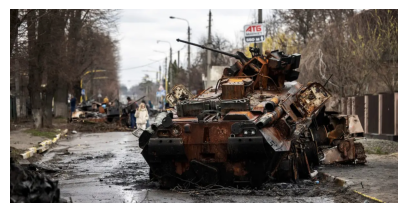

In [257]:
# load another image and turn on classification
uploaded_war = "sample_images/classify/w.webp"
load_image(uploaded_war)
result = await fetch_geolocation(uploaded_war, use_classification=True)

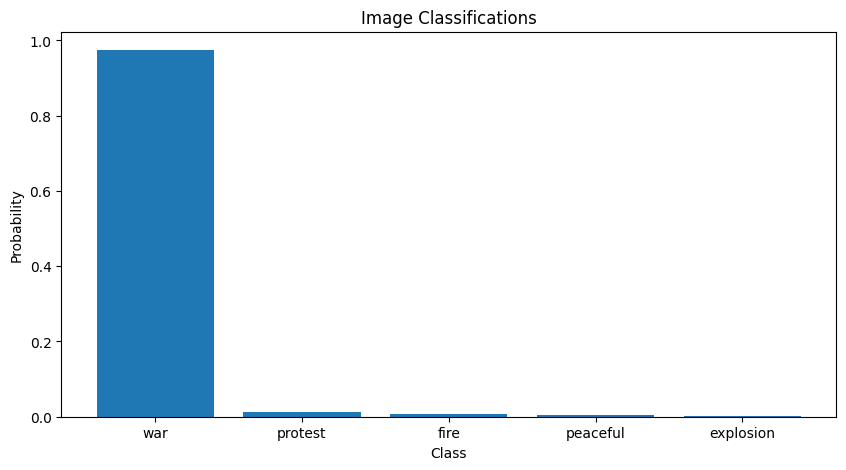

[{'class': 'war', 'score': 0.9743708372116089},
 {'class': 'protest', 'score': 0.011320861056447029},
 {'class': 'fire', 'score': 0.008241592906415462},
 {'class': 'peaceful', 'score': 0.004542134702205658},
 {'class': 'explosion', 'score': 0.0015246403636410832}]

In [273]:
top_classes = result["image_classifications"]
# use matplotlib to display the top classes
plt.figure(figsize=(10, 5))
plt.bar([c["class"] for c in top_classes], [c["score"] for c in top_classes])
plt.ylabel("Probability")
plt.xlabel("Class")
plt.title("Image Classifications")
plt.show()
top_classes

## What if an image has multiple classes? 📊

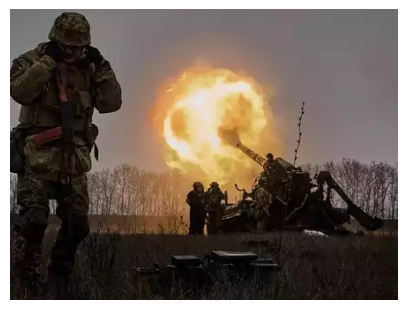

In [259]:
# load another image and turn on classification
uploaded_multi = "sample_images/classify/w2.webp"
load_image(uploaded_multi)
result_multi = await fetch_geolocation(uploaded_multi, use_classification=True)

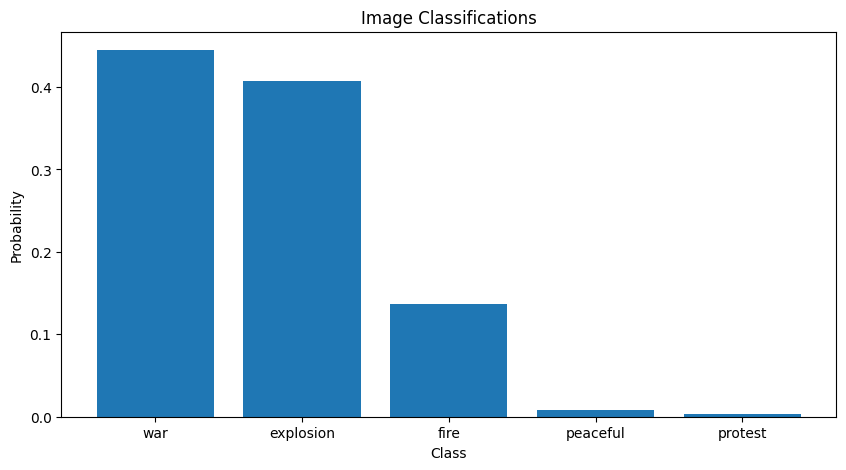

In [260]:
top_classes = result_multi["image_classifications"]
# use matplotlib to display the top 3 classes
plt.figure(figsize=(10, 5))
plt.bar([c["class"] for c in top_classes], [c["score"] for c in top_classes])
plt.ylabel("Probability")
plt.xlabel("Class")
plt.title("Image Classifications")
plt.show()


## Putting it all together 🌍

In [275]:
# get the geolocation of the image and plot the class with the highest probability
# Extract the GPS coordinates and probabilities
geolocation = result_multi["geo_predictions"]
gps_coordinates = [prediction["coordinates"] for prediction in geolocation]
probabilities = [prediction["score"] for prediction in geolocation]

# Normalize the probabilities
total_prob = sum(probabilities)
normalized_probs = [prob / total_prob for prob in probabilities]

# Combine coordinates with normalized probabilities
weighted_coordinates = [(lat, lon, weight*100) for (lat, lon), weight in zip(gps_coordinates, normalized_probs)]  # Multiply weight by 100 for visualization purposes

# Calculate the average location to center the map
avg_lat = sum(lat for lat, _, _ in weighted_coordinates) / len(weighted_coordinates)
avg_lon = sum(lon for _, lon, _ in weighted_coordinates) / len(weighted_coordinates)

# Create a map centered around the average coordinates
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=2)

HeatMap(weighted_coordinates, radius=15).add_to(m)

# Mark top coordinate
top_coordinate = gps_coordinates[0]
top_probability = normalized_probs[0]

folium.Marker(
    location=top_coordinate,
    popup=f"Top Prediction: {top_coordinate} with probability {top_probability:.4f}",
    icon=folium.Icon(color='red', icon='star')
).add_to(m)

# add the class with the highest probability to the map
top_class = top_classes[0]["class"]
top_class_probability = top_classes[0]["score"]

# add the class with the highest probability to the map as a popup marker on the top coordinate
folium.Marker(
    location=top_coordinate,
    popup=f"Top Class: {top_class } with probability {top_class_probability :.4f}", # Include the class and probability in the popup marker
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# Display the map
m



{'status': 200, 'message': 'Success', 'geo_predictions': [{'coordinates': [55.568092346191406, 38.1525993347168], 'score': 0.02995474822819233}, {'coordinates': [54.31420135498047, 47.622352600097656], 'score': 0.027704564854502678}, {'coordinates': [53.78508377075195, 15.846446990966797], 'score': 0.026921801269054413}, {'coordinates': [50.35028076171875, 30.500621795654297], 'score': 0.02665013074874878}, {'coordinates': [50.36123275756836, 30.514183044433594], 'score': 0.02640571817755699}], 'image_classifications': [{'class': 'war', 'score': 0.4448840022087097}, {'class': 'explosion', 'score': 0.4068260192871094}, {'class': 'fire', 'score': 0.13616572320461273}, {'class': 'peaceful', 'score': 0.008384459652006626}, {'class': 'protest', 'score': 0.0037397556006908417}]}


## What about hard images with ambiguous locations? 🌍
There are cases where the location of an image is hard to determine. For example, if there us very little information in the image, or if the image is a generic landscape. In there cases you can ask the api to use clustering to spread out its predictions accross a larger geographical area and return these more general predictions. You can do this by setting the `use_clustering` parameter to `True` in the `geolocalize` function.

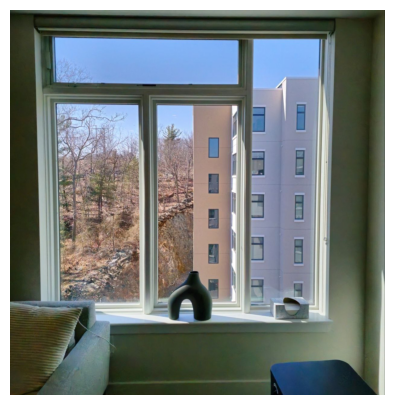

In [262]:
# Load a very generic image that does not contain any specific details. For example we can use an outside the window view of an apartment.
# lets compare the results with and without classification and see how far the geolocation is from the actual location. The actual location for this image 
# is near 42.468955, -71.019451 Suagus, MA 01906 USA
uploaded = "sample_images/where_is_that.jpg"
load_image(uploaded)


In [271]:
result_no_clustering = await fetch_geolocation(uploaded, top_k=5, anti_cluster=False)
print(result_no_clustering)
results_clustering = await fetch_geolocation(uploaded, anti_cluster=True, top_k=3)
print(results_clustering)

# Extract the GPS coordinates and probabilities
geolocation_no_clustering = result_no_clustering["geo_predictions"]
geolocation_clustering = results_clustering["geo_predictions"]
gps_coordinates_no_clustering = [prediction["coordinates"] for prediction in geolocation_no_clustering]
gps_coordinates_clustering = [prediction["coordinates"] for prediction in geolocation_clustering]

# using simple markers plot the top 10 coordinates for both cases, use a great marker with a check icon for the ground truth location
m = folium.Map(location=[42.468955, -71.019451], zoom_start=4)

for coordinate in gps_coordinates_clustering[:1]:
    folium.Marker(
        location=coordinate,
        icon=folium.Icon(color='blue', icon='info-sign', )
    ).add_to(m)
for coordinate in gps_coordinates_no_clustering:
    folium.Marker(
        location=coordinate,
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)



# add the ground truth location
folium.Marker(
    location=[42.468955, -71.019451],
    popup="Ground Truth Location",
    icon=folium.Icon(color='green', icon='ok-sign')
).add_to(m)

m


{'status': 200, 'message': 'Success', 'geo_predictions': [{'coordinates': [41.07482147216797, -73.70984649658203], 'score': 0.013064643368124962}, {'coordinates': [40.95069885253906, -73.82511901855469], 'score': 0.009602793492376804}, {'coordinates': [41.113372802734375, -73.71968078613281], 'score': 0.00929525587707758}, {'coordinates': [40.96042251586914, -73.85631561279297], 'score': 0.006733521819114685}, {'coordinates': [41.34566879272461, -72.91529846191406], 'score': 0.004679934121668339}]}
{'status': 200, 'message': 'Success', 'geo_predictions': [{'coordinates': [42.28384780883789, -71.3457260131836], 'score': 0.004545473959296942}, {'coordinates': [38.95218276977539, -77.34808349609375], 'score': 0.0034117810428142548}, {'coordinates': [40.95069885253906, -73.82511901855469], 'score': 0.009602793492376804}, {'coordinates': [41.34566879272461, -72.91529846191406], 'score': 0.004679934121668339}, {'coordinates': [41.07482147216797, -73.70984649658203], 'score': 0.01306464336812

## So what does anti clustering do? 🌍
Before we get into that we first have to discuss how GeoSpy works a little bit. GeoSpy is trained to detect the features present in an image and then use these features to predict the location of the image. However, sometimes the features present in an image are not enough to accurately predict the location of the image. In these cases, we can use clustering to spread out its predictions across a larger geographical area and return these more general predictions. In the example above the photo shows features that are common in the northeastern United State. If we just get the top 5 predictions from the API, the top 5 results will all be near and around NYC. The anti clustering parameter is used to prevent this from happening. When the anti clustering parameter is set to `True` GeoSpy will try to generate predictions in multiple regions that match those similar features but not all in the same region. As we can see here, we generate predictions in, NYC, Washington DC, and Boston. GeoSpy will then compare all regions and return the most likely region. As we can see, the first reigon is near Boston and much closer to the ground truth location then the top 5 predictions from the previous example. This feature is still in beta and may not always work as expected but it is a good way to get more accurate predictions in some cases.